Dataset Shape: (45211, 17)
Feature Shape After Encoding: (45211, 38)
Train: 31647 | Val: 6782 | Test: 6782

Training with Batch GD


C:\Users\D KAVINKUMAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 200.
Completed in 47.78 sec

Training with SGD
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.
Completed in 2007.15 sec

Training with Mini-Batch
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Completed in 21.22 sec

Training with Momentum
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Completed in 20.91 sec

Training with Nesterov
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Completed in 21.55 sec


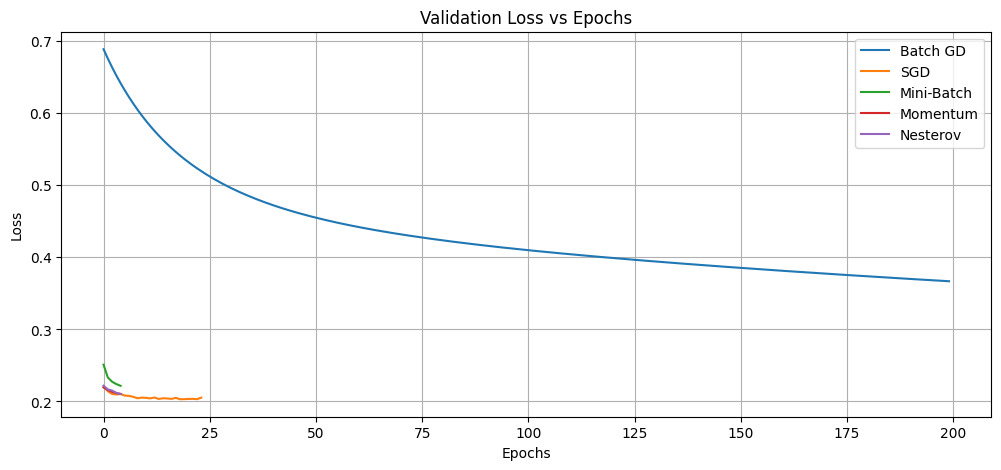

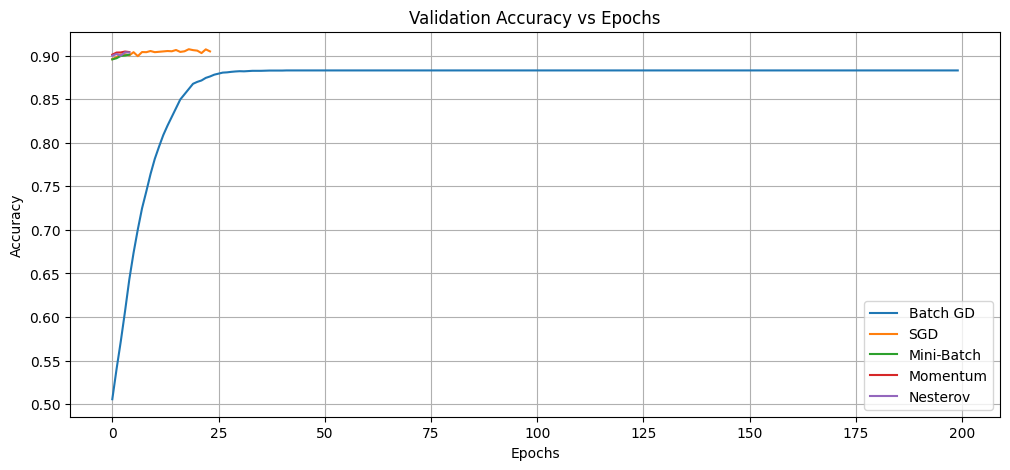


Mini-Batch Training with batch size 16
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.

Mini-Batch Training with batch size 32
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.

Mini-Batch Training with batch size 64
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


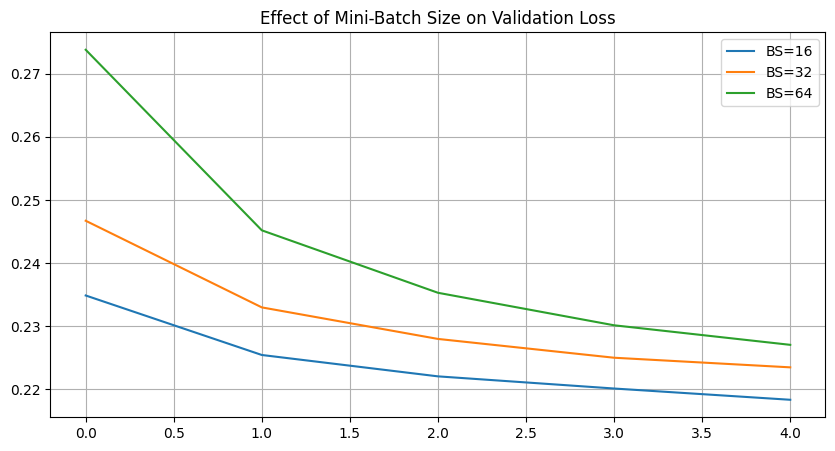


Best Optimizer: SGD
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Test Performance:
Accuracy : 0.9006192863462106
Precision: 0.6155339805825243
Recall   : 0.39974779319041615
F1-score : 0.4847094801223242


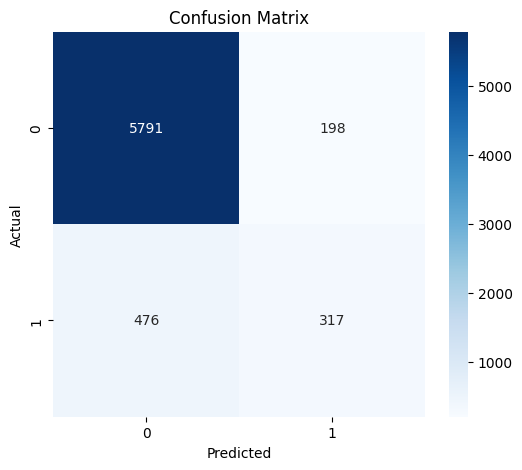

In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD


# ------------------ Reproducibility ------------------

np.random.seed(42)
tf.random.set_seed(42)


# ------------------ LOAD DATASET ------------------

df = pd.read_csv(
    r"C:\Users\D KAVINKUMAR\Downloads\bank+marketing\bank-full.csv",
    sep=';'
)

print("Dataset Shape:", df.shape)


# ------------------ PREPROCESSING ------------------

# Replace 'unknown' with NaN and forward fill
df.replace("unknown", np.nan, inplace=True)
df.ffill(inplace=True)

# Encode target
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Separate features and target
X = df.drop('y', axis=1)
y = df['y']

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

print("Feature Shape After Encoding:", X.shape)


# ------------------ TRAIN / VAL / TEST SPLIT ------------------

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")


# ------------------ FEATURE SCALING ------------------

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# ------------------ MODEL BUILDER ------------------

def build_model(input_dim, optimizer):

    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


# ------------------ OPTIMIZERS ------------------

optimizers = {
    "Batch GD": SGD(learning_rate=0.01),
    "SGD": SGD(learning_rate=0.01),
    "Mini-Batch": SGD(learning_rate=0.01),
    "Momentum": SGD(learning_rate=0.01, momentum=0.9),
    "Nesterov": SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
}

batch_sizes = {
    "Batch GD": len(X_train),
    "SGD": 1,
    "Mini-Batch": 32,
    "Momentum": 32,
    "Nesterov": 32
}


# ------------------ EARLY STOPPING ------------------

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


# ------------------ STORAGE ------------------

histories = {}
times = {}
models = {}


# ------------------ TRAINING LOOP ------------------

for name, opt in optimizers.items():

    print(f"\nTraining with {name}")

    model = build_model(X_train.shape[1], opt)

    start = time.time()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=batch_sizes[name],
        callbacks=[early_stop],
        verbose=0
    )

    end = time.time()

    histories[name] = history
    times[name] = end - start
    models[name] = model

    print(f"Completed in {times[name]:.2f} sec")


# ------------------ PLOT: VALIDATION LOSS ------------------

plt.figure(figsize=(12, 5))

for name, hist in histories.items():
    plt.plot(hist.history['val_loss'], label=name)

plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


# ------------------ PLOT: VALIDATION ACCURACY ------------------

plt.figure(figsize=(12, 5))

for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=name)

plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


# ------------------ MINI-BATCH SIZE ANALYSIS ------------------

batch_tests = [16, 32, 64]
batch_histories = {}

for bs in batch_tests:

    print(f"\nMini-Batch Training with batch size {bs}")

    opt = SGD(learning_rate=0.01)

    model = build_model(X_train.shape[1], opt)

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=bs,
        callbacks=[early_stop],
        verbose=0
    )

    batch_histories[bs] = hist


plt.figure(figsize=(10, 5))

for bs, hist in batch_histories.items():
    plt.plot(hist.history['val_loss'], label=f"BS={bs}")

plt.title("Effect of Mini-Batch Size on Validation Loss")
plt.legend()
plt.grid()
plt.show()


# ------------------ BEST OPTIMIZER ------------------

val_acc = {
    name: hist.history['val_accuracy'][-1]
    for name, hist in histories.items()
}

best_optimizer = max(val_acc, key=val_acc.get)

best_model = models[best_optimizer]

print("\nBest Optimizer:", best_optimizer)


# ------------------ TEST EVALUATION ------------------

y_pred_prob = best_model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


print("\nTest Performance:")

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)


# ------------------ CONFUSION MATRIX ------------------

plt.figure(figsize=(6, 5))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues'
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()
